In [1]:
from src.data import load_csv_files, merge_multiple_dataframes

In [2]:
dfs = load_csv_files()
final_df = merge_multiple_dataframes(dfs)

In [15]:
final_df.columns

Index(['datetime', 'machineID', 'volt', 'rotate', 'pressure', 'vibration',
       'errorID', 'failure', 'comp', 'model', 'age', 'failure_flag'],
      dtype='object')

In [18]:
final_df.groupby(["machineID", "datetime"], as_index=False).max()

,machineID,datetime,volt,rotate,pressure,vibration,errorID,failure,comp,model,age,failure_flag
0,1,2015-01-01 06:00:00,176.217853,418.504078,113.077935,45.087686,none,none,none,model3,18,0
1,1,2015-01-01 07:00:00,162.879223,402.747490,95.460525,43.413973,none,none,none,model3,18,0
2,1,2015-01-01 08:00:00,170.989902,527.349825,75.237905,34.178847,none,none,none,model3,18,0
3,1,2015-01-01 09:00:00,162.462833,346.149335,109.248561,41.122144,none,none,none,model3,18,0
4,1,2015-01-01 10:00:00,157.610021,435.376873,111.886648,25.990511,none,none,none,model3,18,0
...,...,...,...,...,...,...,...,...,...,...,...,...
876095,100,2016-01-01 02:00:00,179.438162,395.222827,102.290715,50.771941,none,none,none,model4,5,0
876096,100,2016-01-01 03:00:00,189.617555,446.207972,98.180607,35.123072,none,none,none,model4,5,0
876097,100,2016-01-01 04:00:00,192.483414,447.816524,94.132837,48.314561,none,none,none,model4,5,0
876098,100,2016-01-01 05:00:00,165.475310,413.771670,104.081073,44.835259,none,none,none,model4,5,0


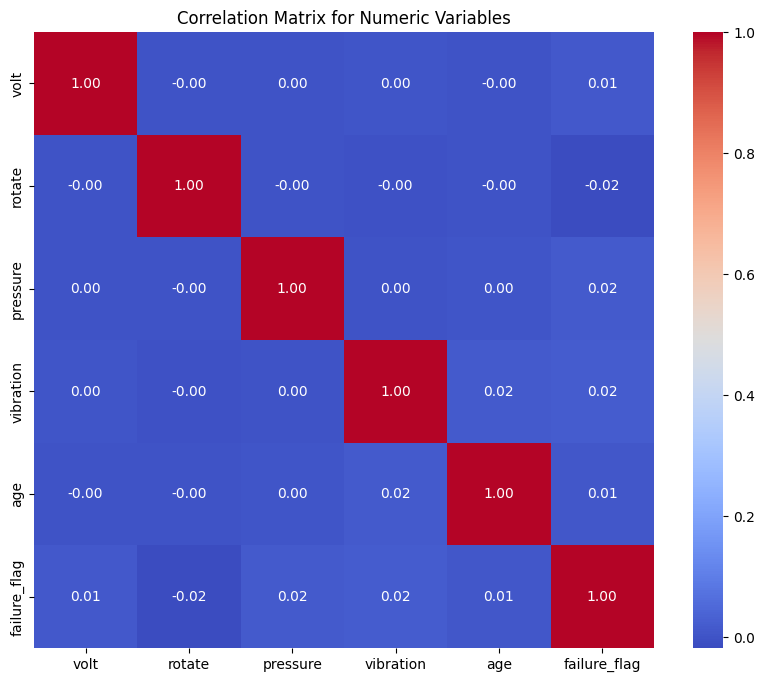

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Choose numeric columns (adjust this list as needed)
numeric_cols = ["volt", "rotate", "pressure", "vibration", "age", "failure_flag"]


# Compute correlation matrix
corr_matrix = final_df[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix for Numeric Variables")
plt.show()

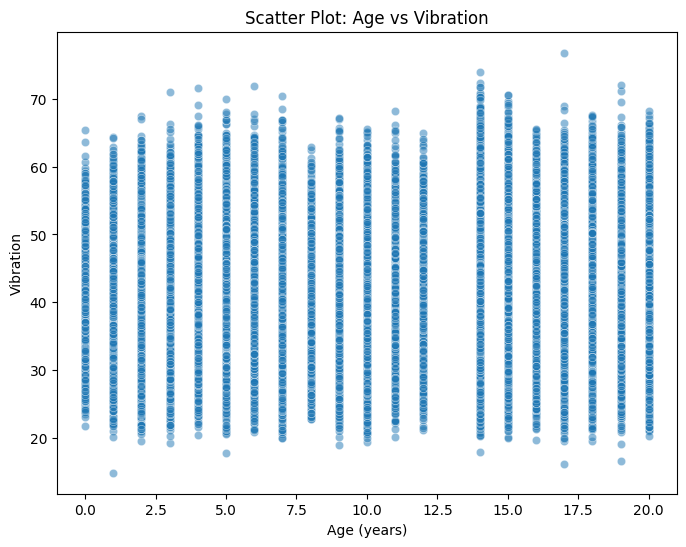

In [4]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=final_df, x="age", y="vibration", alpha=0.5)
plt.title("Scatter Plot: Age vs Vibration")
plt.xlabel("Age (years)")
plt.ylabel("Vibration")
plt.show()

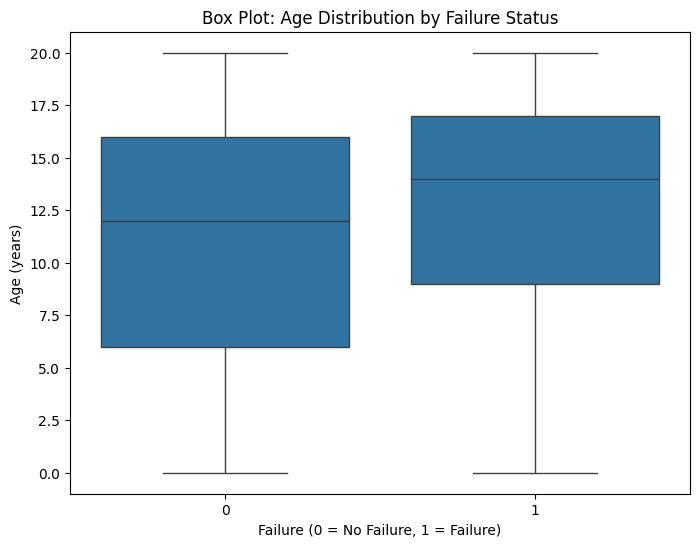

In [5]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="failure_flag", y="age", data=final_df)
plt.title("Box Plot: Age Distribution by Failure Status")
plt.xlabel("Failure (0 = No Failure, 1 = Failure)")
plt.ylabel("Age (years)")
plt.show()

In [6]:
lm_model = smf.ols("vibration ~ age", data=final_df).fit()
print("Linear Regression Summary (Vibration ~ Age):")
print(lm_model.summary())

# Logistic regression: effect of age on failure probability
logit_model = smf.logit("failure_flag ~ age", data=final_df).fit()
print("\nLogistic Regression Summary (Failure ~ Age):")
print(logit_model.summary())


Linear Regression Summary (Vibration ~ Age):
                            OLS Regression Results                            
Dep. Variable:              vibration   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     273.5
Date:                Wed, 02 Apr 2025   Prob (F-statistic):           1.97e-61
Time:                        16:34:40   Log-Likelihood:            -2.7193e+06
No. Observations:              877209   AIC:                         5.439e+06
Df Residuals:                  877207   BIC:                         5.439e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interce

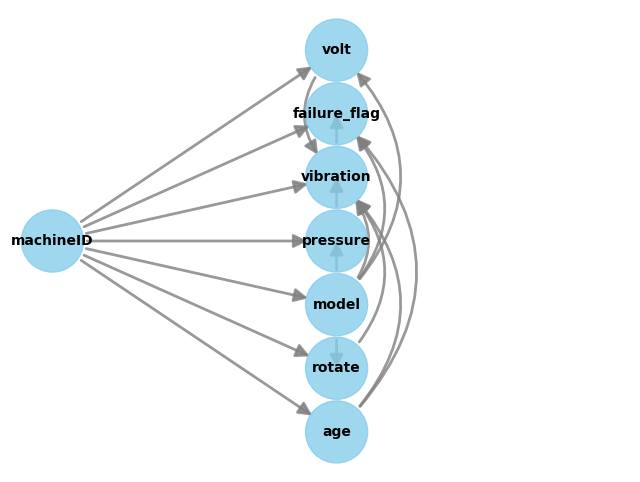

In [12]:

from dowhy import CausalModel

# Define a preliminary causal graph.
# This is an example graph; you need to refine it with domain expertise.
causal_graph = """
digraph {
 
    machineID -> model;
    machineID -> age;
    machineID -> volt;
    machineID -> rotate;
    machineID -> pressure;
    machineID -> vibration;
    machineID -> failure_flag;

   
    model -> volt;
    model -> rotate;
    model -> pressure;
    model -> vibration;
    model -> failure_flag;

  
    age -> vibration;
    age -> failure_flag;

    volt -> vibration;
    rotate -> vibration;
    pressure -> vibration;


    vibration -> failure_flag;
}
"""

# For computational ease, you might sample the data if the full dataset is large.
df_sample = final_df.sample(n=10000, random_state=42)

causal_model = CausalModel(
    data=df_sample, treatment="age", outcome="vibration", graph=causal_graph
)

# Visualize the causal graph (this will generate a file named 'causal_model.png')
causal_model.view_model()


In [13]:


# Identify the causal effect using back-door adjustment
identified_estimand = causal_model.identify_effect()
print("\nIdentified Estimand:")
print(identified_estimand)

# Estimate the effect using a linear regression method (as an example)
causal_estimate = causal_model.estimate_effect(
    identified_estimand, method_name="backdoor.linear_regression"
)
print("\nCausal Estimate (Effect of Age on Vibration):")
print(causal_estimate)

# Refutation to test the robustness of the estimate
refute_results = causal_model.refute_estimate(
    identified_estimand, causal_estimate, method_name="random_common_cause"
)
print("\nRefutation Results:")
print(refute_results)



Identified Estimand:
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                           
──────(E[vibration|machineID])
d[age]                        
Estimand assumption 1, Unconfoundedness: If U→{age} and U→vibration then P(vibration|age,machineID,U) = P(vibration|age,machineID)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!


Causal Estimate (Effect of Age on Vibration):
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                           
──────(E[vibration|machineID])
d[age]                        
Estimand assumption 1, Unconfoundedness: If U→{age} and U→vibration then P(vibration|age,machineID,U) = P(vibration|age,machineID)

## Realized estimand
b: vibration~age+machineID+age*pressure+age*volt+age*model+ag